<h1> Library selection

In [5]:
import numpy
import numpy as np
from mat4py import loadmat
import pandas as pd
from sklearn import tree, svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import plotly.express as px
import os
import graphviz
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

def scaler(X):
    X = (X-np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X

def data_prepare(return_total = True):
    data = loadmat('ML-R-MG.mat')
    data_training = data['trainingset_HTEonly']
    data_test = data['testset_HTEonly']
    data_liter = data['allset_Literature']
    data_training = np.asarray(data_training, dtype=np.float64)
    data_test = np.asarray(data_test, dtype=np.float64)
    data_liter = np.asarray(data_liter, dtype=np.float64)

    x_train = np.c_[data_training[:,1]*100000000,data_training[:,3]*100,data_training[:,4],data_training[:,5],data_training[:,6]]
    x_test = np.c_[data_test[:,1]*100000000,data_test[:,3]*100,data_test[:,4],data_test[:,5],data_test[:,6]]
    x_ind = np.c_[data_liter[:,1]*100000000,data_liter[:,3]*100,data_liter[:,4],data_liter[:,5],data_liter[:,6]]
    y_train = data_training[:, 8]
    y_test = data_test[:, 8]
    y_ind = data_liter[:, 8]

    x_total = np.concatenate((x_test, x_train), axis=0)
    y_total = np.concatenate((y_test, y_train), axis=0)
    if return_total:
        return x_total, y_total, x_ind, y_ind
    else:
        return x_train, y_train, x_test, y_test

def k_fold_cross_validation(model, k, x_set, y_set, x_ind, y_ind, scaler = None, ann=False):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    model_train_score_list = []
    model_test_score_list = []
    model_ind_score_list = []
    model_coef_score_list = []

    if scaler == "MinMax":
        scaler = MinMaxScaler()
        scaler.fit(x_set)
        fed_x_set = scaler.transform(x_set)
        fed_x_ind = scaler.transform(x_ind)
    elif scaler == "Cheat":
        scaler = StandardScaler()
        x_total = np.concatenate((x_set, x_ind), axis=0)
        scaler.fit(x_total)
        fed_x_set = scaler.transform(x_set)
        fed_x_ind = scaler.transform(x_ind)
    elif scaler == "MinMax_Cheat":
        scaler = MinMaxScaler()
        x_total = np.concatenate((x_set, x_ind), axis=0)
        scaler.fit(x_total)
        fed_x_set = scaler.transform(x_set)
        fed_x_ind = scaler.transform(x_ind)
    else:
        fed_x_set = x_set
        fed_x_ind = x_ind

    for train_index, test_index in skf.split(fed_x_set, y_set):
        x_train, x_test = fed_x_set[train_index], fed_x_set[test_index]
        y_train, y_test = y_set[train_index], y_set[test_index]
        if ann:

            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
            mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

            model.fit(x_train, y_train, batch_size=20, epochs=1500, validation_data=(x_test, y_test), callbacks=[es, mc], verbose=0)
        else:
            model.fit(x_train, y_train)
        try:
            model_train_score_list.append(model.score(x_train, y_train))
            model_test_score_list.append(model.score(x_test, y_test))
            model_ind_score_list.append(model.score(fed_x_ind, y_ind))
        except:

            model_train_score_list.append(model.evaluate(x_train, y_train)[1])
            model_test_score_list.append(model.evaluate(x_test, y_test)[1])
            model_ind_score_list.append(model.evaluate(fed_x_ind, y_ind)[1])
        try:
            model_coef_score_list.append(model.coef_)
        except:
            model_coef_score_list.append([])
    sum_dict = {"Train_S": model_train_score_list, "Test_S": model_test_score_list, "Lit_S": model_ind_score_list, "Coef": model_coef_score_list}
    return pd.DataFrame(sum_dict)

def show_anal(df_model_result, name_model):
    print(name_model + ":")
    print(df_model_result[["Train_S", "Test_S", "Lit_S"]].describe())
    for i in list(df_model_result["Coef"]):
        if len(i) > 0:
            print(i)

def ANN(input_dim=2):
    mdl = Sequential()

    mdl.add(Dense(50, input_dim=input_dim, activation='relu'))
    mdl.add(Dense(1, activation='sigmoid'))
    mdl.compile(optimizer=Adam(learning_rate=1e-2), loss="binary_crossentropy", metrics=['accuracy'])
    return mdl


def SVC():
    svc = svm.SVC(kernel="linear", C=1)
    return svc

def model_based_on_db(data, input_column):
    x = np.array(data[input_column])
    y = np.array(data["Amorphous"])

    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)
    x_scaled_train, x_scaled_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

    model = ANN(len(input_column))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

    model.fit(x_scaled_train, y_train, batch_size=20, epochs=1500, validation_data=(x_scaled_test, y_test), callbacks=[es, mc], verbose=0)
    train_score = model.evaluate(x_scaled_train, y_train)[1]
    test_score = model.evaluate(x_scaled_test, y_test)[1]
    return model, train_score, test_score, scaler

def show_model_visualization(model, scaler,size):
    delta = np.arange(0,13,0.1)
    rho = np.arange(0,2.8,0.02)
    list_aaa = []
    for i in rho:
        ex_resis = 10 ** i
        for j in delta:
            list_aaa.append([ex_resis, j])

    df = pd.DataFrame(list_aaa,columns = ["Ex_resistivity", "delta"])

    fed_df = scaler.transform(df)
    y = model.predict(fed_df)
    fig_model_vis = plt.figure()
    ax_model_vis = fig.add_subplot(111)
    plt.scatter(x=df["Ex_resistivity"], y=df["delta"],
                c= y.reshape(1,-1)[0],s=size)
    plt.xscale("log")
    plt.xlim([1,10 ** 2.7])
    plt.ylim([0,13])
    plt.show()
    return fig_model_vis

<h1> Data preparation

In [27]:
data_from_db = pd.read_csv("compare.csv")
val_data_from_db = pd.read_csv("deletethis.csv")
val_data_from_db_ex = pd.read_csv("deletethis_ex.csv")
x_total, y_total, x_ind, y_ind = data_prepare()
data_from_paper = pd.DataFrame(x_total, columns=["Ex_resistivity", "delta", "dHmix", "ENavg", "dEN"])
data_from_paper["Amorphous"] = y_total
data_from_literature = pd.DataFrame(x_ind, columns=["Ex_resistivity", "delta", "dHmix", "ENavg", "dEN"])
data_from_literature["Amorphous"] = y_ind


<h1> ANN from paper, database

In [17]:
model_paper, train_score_paper, test_score_paper, scaler_paper = model_based_on_db(data_from_paper, ["Ex_resistivity", "delta"])
model_db, train_score_db, test_score_db, scaler_db = model_based_on_db(data_from_db, ["Ex_resistivity", "delta"])
print(train_score_paper, test_score_paper)
print(train_score_db, test_score_db)

Epoch 334: early stopping
2/2 [==============================] - 0s 976us/step - loss: 0.3541 - accuracy: 0.8361
Epoch 332: early stopping
2/2 [==============================] - 0s 1000us/step - loss: 0.3427 - accuracy: 0.8710
0.863070547580719 0.8360655903816223
0.868852436542511 0.8709677457809448


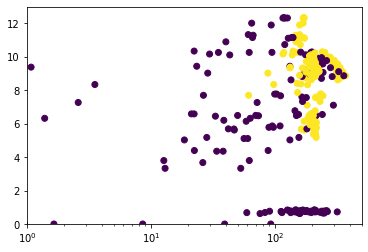

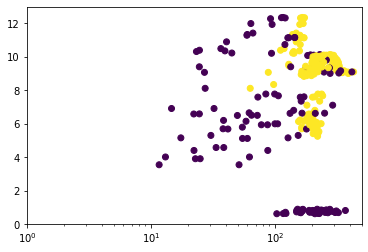

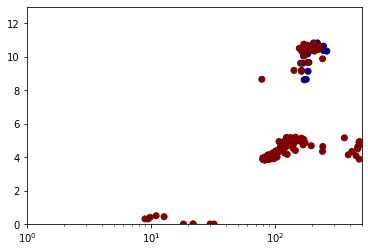

In [16]:
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in data_from_paper]
    plt.scatter(x=data_from_paper["Ex_resistivity"], y=data_from_paper["delta"],
                c= data_from_paper["Amorphous"],label= ["Amorphous", "D"])
    plt.xscale("log")
    plt.xlim([1,10 ** 2.7])
    plt.ylim([0,13])
    plt.show()
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in data_from_db]
    plt.scatter(x=data_from_db["Ex_resistivity"], y=data_from_db["delta"],
                c= data_from_db["Amorphous"],label= ["Amorphous", "D"])
    plt.xscale("log")
    plt.xlim([1,10 ** 2.7])
    plt.ylim([0,13])
    plt.show()
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in val_data_from_db]
    plt.scatter(x=val_data_from_db["Ex_resistivity"], y=val_data_from_db["delta"],
                c= val_data_from_db["Amorphous"],label= ["Amorphous", "D"],
               cmap="jet_r")
    plt.xscale("log")
    plt.xlim([1,10 ** 2.7])
    plt.ylim([0,13])
    plt.show()

C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


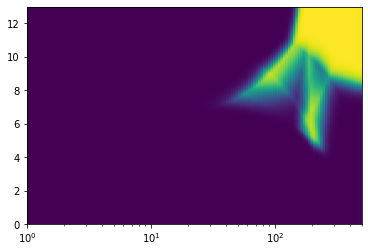

C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


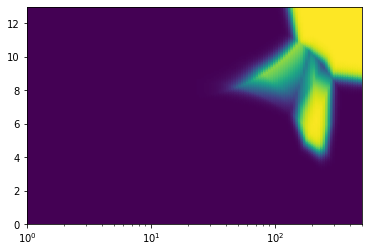

In [19]:

fig_paper = show_model_visualization(model_paper, scaler_paper,8)
fig_db = show_model_visualization(model_db, scaler_db,8)

In [18]:
fed_val_x_set_paper = scaler_paper.transform(val_data_from_db[["Ex_resistivity", "delta"]])
print(model_paper.evaluate(fed_val_x_set_paper, val_data_from_db["Amorphous"])[1])
fed_val_x_set_db = scaler_db.transform(val_data_from_db[["Ex_resistivity", "delta"]])
print(model_db.evaluate(fed_val_x_set_db, val_data_from_db["Amorphous"])[1])

6/6 [==============================] - 0s 1ms/step - loss: 0.2671 - accuracy: 0.8564
0.8563535809516907


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.2621 - accuracy: 0.8508
0.8508287072181702


In [21]:
model_paper, train_score_paper, test_score_paper, scaler_paper = model_based_on_db(data_from_paper, ["Ex_resistivity", "delta", "dHmix"])
model_db, train_score_db, test_score_db, scaler_db = model_based_on_db(data_from_db, ["Ex_resistivity", "delta", "dHmix"])
print(train_score_paper, test_score_paper)
print(train_score_db, test_score_db)
fed_val_x_set_paper = scaler_paper.transform(val_data_from_db[["Ex_resistivity", "delta", "dHmix"]])
fed_val_x_set_db = scaler_db.transform(val_data_from_db[["Ex_resistivity", "delta", "dHmix"]])
print(model_paper.evaluate(fed_val_x_set_paper, val_data_from_db["Amorphous"])[1])
print(model_db.evaluate(fed_val_x_set_db, val_data_from_db["Amorphous"])[1])

Epoch 385: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.9508
Epoch 372: early stopping
2/2 [==============================] - 0s 1ms/step - loss: 0.1310 - accuracy: 0.9355
0.954356849193573 0.9508196711540222
0.9672130942344666 0.9354838728904724
6/6 [==============================] - 0s 1ms/step - loss: 4.9491 - accuracy: 0.6077
0.6077347993850708


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.3241 - accuracy: 0.8729
0.8729282021522522


Epoch 518: early stopping
5/5 [==============================] - 0s 1000us/step - loss: 0.1296 - accuracy: 0.9554
Model Trial 1, Train:0.8713693022727966, Test:0.8360655903816223, Val:0.8508287072181702, Val_ex:0.9554139971733093


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


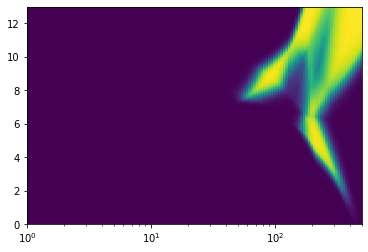

Epoch 274: early stopping
5/5 [==============================] - 0s 1ms/step - loss: 0.0748 - accuracy: 0.9618
Model Trial 2, Train:0.8589211702346802, Test:0.7868852615356445, Val:0.8397790193557739, Val_ex:0.9617834687232971


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


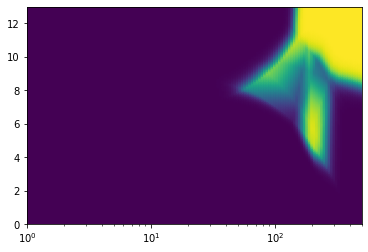

Epoch 178: early stopping
5/5 [==============================] - 0s 1ms/step - loss: 0.0735 - accuracy: 0.9745
Model Trial 3, Train:0.8340249061584473, Test:0.8196721076965332, Val:0.8508287072181702, Val_ex:0.9745222926139832


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


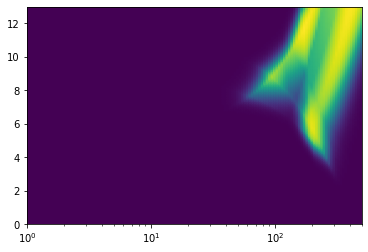

Epoch 162: early stopping
5/5 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9873
Model Trial 4, Train:0.8049792647361755, Test:0.8360655903816223, Val:0.8674033284187317, Val_ex:0.987261176109314


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


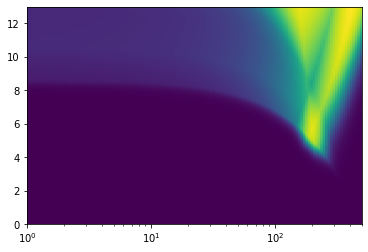

Epoch 193: early stopping
5/5 [==============================] - 0s 1ms/step - loss: 0.0852 - accuracy: 0.9682


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model Trial 5, Train:0.8298755288124084, Test:0.8032786846160889, Val:0.8563535809516907, Val_ex:0.9681528806686401


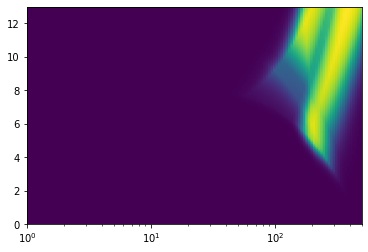

Epoch 202: early stopping
5/5 [==============================] - 0s 1ms/step - loss: 0.1140 - accuracy: 0.9618
Model Trial 6, Train:0.8464730381965637, Test:0.8196721076965332, Val:0.8397790193557739, Val_ex:0.9617834687232971


C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


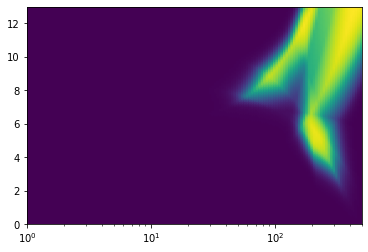

In [29]:
for i in range(6):
    model_paper, train_score_paper, test_score_paper, scaler_paper = model_based_on_db(data_from_paper, ["Ex_resistivity", "delta"])
    
    fed_val_x_set_paper = scaler_paper.transform(val_data_from_db[["Ex_resistivity", "delta"]])
    val_score = model_paper.evaluate(fed_val_x_set_paper, val_data_from_db["Amorphous"])[1]
    
    fed_val_x_set_paper_ex = scaler_paper.transform(val_data_from_db_ex[["Ex_resistivity", "delta"]])
    val_score_ex = model_paper.evaluate(fed_val_x_set_paper_ex, val_data_from_db_ex["Amorphous"])[1]
 
    print(f"Model Trial {i + 1}, Train:{train_score_paper}, Test:{test_score_paper}, Val:{val_score}, Val_ex:{val_score_ex}")
    fig_paper = show_model_visualization(model_paper, scaler_paper,8)

In [26]:
val_data_from_db

Unnamed: 0     X     Y         Al   Ti   Cr   Fe     Co         Ni  \
0             0 -15.0 -15.0  12.287869  0.0  0.0  0.0   0.00  21.681179   
1             1 -15.0 -35.0  10.402484  0.0  0.0  0.0   0.00  20.290501   
2             2 -15.0  15.0  18.519799  0.0  0.0  0.0   0.00  17.574368   
3             3 -25.0 -25.0  11.640133  0.0  0.0  0.0   0.00  23.953121   
4             4 -25.0  -5.0  16.567091  0.0  0.0  0.0   0.00  23.887162   
..          ...   ...   ...        ...  ...  ...  ...    ...        ...   
176           0 -27.5 -27.5   0.000000  0.0  0.0  0.0  97.71   2.290000   
177           1 -27.5  27.5   0.000000  0.0  0.0  0.0  96.68   3.320000   
178           2   0.0   0.0   0.000000  0.0  0.0  0.0  96.15   3.850000   
179           3  27.5 -27.5   0.000000  0.0  0.0  0.0  99.61   0.390000   
180           4  27.5  27.5   0.000000  0.0  0.0  0.0  95.64   4.360000   

            Cu  ...   Mo    W   Thickness  Resistivity  Ex_resistivity  \
0    13.461793  ...  0.0  0.0  652.565524   206.632916      182.447276   
1    10.977455  ...  0.0  0.0  843.664305   246.506055      220.083311   
2    21.285476  ...  0.0  0.0  592.131016   214.856515      194.847496   
3    12.444275  ...  0.0  0.0  752.011776   243.572854      219.519424   
4    15.993664  ...  0.0  0.0  620.889400   223.322741      202.624532   
..         ...  ...  ...  ...         ...          ...             ...   
176   0.000000  ...  0.0  0.0  142.933333    28.094676       21.838875   
177   0.000000  ...  0.0  0.0  130.700000    36.245685       29.982777   
178   0.000000  ...  0.0  0.0  140.850000    38.525405       32.258840   
179   0.000000  ...  0.0  0.0  108.900000    28.162259       21.919568   
180   0.000000  ...  0.0  0.0  132.025000    24.557363       18.287279   

         delta      dHmix        Compo Deposition Amorphous  
0    10.684094 -42.162516  Zi/Cu/Ni/Al         as         1  
1    10.444158 -41.314078  Zi/Cu/Ni/Al         as         1  
2    10.475879 -39.342461  Zi/Cu/Ni/Al         as         1  
3    10.827688 -43.024416  Zi/Cu/Ni/Al         as         1  
4    10.752219 -42.475096  Zi/Cu/Ni/Al         as         1  
..         ...        ...          ...        ...       ...  
176   0.000000   0.000000        Co/Ni         as         0  
177   0.000000   0.000000        Co/Ni         as         0  
178   0.000000   0.000000        Co/Ni         as         0  
179   0.000000   0.000000        Co/Ni         as         0  
180   0.000000   0.000000        Co/Ni         as         0  

[181 rows x 21 columns]

In [71]:
pd.DataFrame(lst).describe()

0
count  10.000000
mean    0.491667
std     0.029788
min     0.437500
25%     0.479167
50%     0.479167
75%     0.515625
max     0.541667

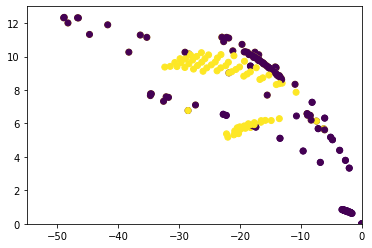

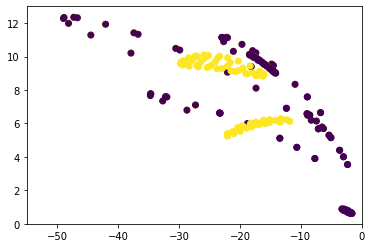

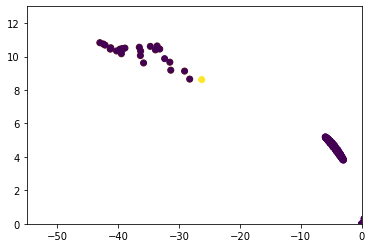

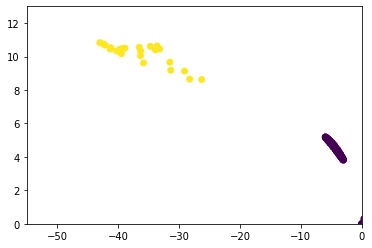

In [31]:
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in data_from_paper]
    plt.scatter(x=data_from_paper["dHmix"], y=data_from_paper["delta"],
                c= data_from_paper["Amorphous"],label= ["Amorphous", "D"])
    plt.xlim([-55, 0])
    plt.ylim([0,13])
    plt.show()
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in data_from_db]
    plt.scatter(x=data_from_db["dHmix"], y=data_from_db["delta"],
                c= data_from_db["Amorphous"],label= ["Amorphous", "D"])
    plt.xlim([-55, 0])
    plt.ylim([0,13])
    plt.show()
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in val_data_from_db]
    plt.scatter(x=val_data_from_db["dHmix"], y=val_data_from_db["delta"],
                c= val_data_from_db["Amorphous"],label= ["Amorphous", "D"])
    plt.xlim([-55, 0])
    plt.ylim([0,13])
    plt.show()
if True:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crystalline = ["Crystalline" if a == 0 else "Amorphous" for a in val_data_from_db]
    plt.scatter(x=val_data_from_db_ex["dHmix"], y=val_data_from_db_ex["delta"],
                c= val_data_from_db_ex["Amorphous"],label= ["Amorphous", "D"])
    plt.xlim([-55, 0])
    plt.ylim([0,13])
    plt.show()

In [18]:
print(x_total)

[[ 3.82000000e+01  4.35169190e+00 -9.62944119e+00  1.88250804e+00
   9.70371980e-02]
 [ 1.99973000e+02  9.37041880e+00 -3.23584721e+01  1.57808438e+00
   2.42259337e-01]
 [ 2.29754000e+02  9.53122480e+00 -1.59620615e+01  1.61310764e+00
   2.46205871e-01]
 ...
 [ 2.02545000e+02  6.04781690e+00 -1.76391308e+01  1.61190348e+00
   5.01985050e-02]
 [ 2.06211000e+02  5.85235830e+00 -1.93157887e+01  1.60971817e+00
   4.85760860e-02]
 [ 2.03850000e+02  5.37766240e+00 -2.22167952e+01  1.60161978e+00
   4.73862720e-02]]


In [85]:
val_data_from_db = pd.read_csv("deletethis.csv")
val_x_from_db = np.array(val_data_from_db[["Ex_resistivity", "delta"]])
val_y_from_db = np.array(val_data_from_db["Amorphous"])

fed_val_x_set_db = scaler.transform(val_x_from_db)
print(model.evaluate(fed_val_x_set_db, val_y_from_db)[1])
print(model.predict(fed_val_x_set_db))

2/2 [==============================] - 0s 2ms/step - loss: 1.7091 - accuracy: 0.5000
0.5
[[0.0312117 ]
 [0.03421226]
 [0.03262612]
 [0.03278393]
 [0.03209314]
 [0.03610873]
 [0.03317401]
 [0.03724697]
 [0.03307995]
 [0.03143477]
 [0.03313577]
 [0.03122944]
 [0.03554454]
 [0.0319716 ]
 [0.03508461]
 [0.03866333]
 [0.03711534]
 [0.03393242]
 [0.03521109]
 [0.03835779]
 [0.03416497]
 [0.03268683]
 [0.03209475]
 [0.03167275]
 [0.03022689]
 [0.03329003]
 [0.03088495]
 [0.03159648]
 [0.03029859]
 [0.03399447]
 [0.03160158]
 [0.0356856 ]
 [0.03213087]
 [0.03058448]
 [0.03141263]
 [0.03044894]
 [0.0343678 ]
 [0.03195438]
 [0.03383067]
 [0.03567073]
 [0.03538206]
 [0.0346109 ]
 [0.03388122]
 [0.03848574]
 [0.03273979]
 [0.03210604]
 [0.03125647]
 [0.031201  ]]


In [30]:
pd.DataFrame(x_from_db, columns = ["Ex_resistivity", "delta"]).describe()

Ex_resistivity       delta
count      304.000000  304.000000
mean       185.462640    7.478871
std         87.173223    3.304236
min         -3.382795    0.614099
25%        138.826660    5.922430
50%        197.870612    9.045878
75%        230.023627    9.781147
max        430.814763   12.348686

In [32]:
pd.DataFrame(x_total[:,[0,1]], columns = ["Ex_resistivity", "delta"]).describe()

Ex_resistivity       delta
count      302.000000  302.000000
mean       172.278752    7.334821
std         82.727602    3.440989
min          0.632000    0.000000
25%        126.000000    5.717845
50%        183.644500    8.845213
75%        214.712750    9.779757
max        371.331000   12.341625

<h1>Plots
<h2> paper

In [60]:
import plotly.express as px
df_paper = pd.DataFrame(x_total[:,[0,1]], columns = ["Ex_resistivity", "delta"])
fig = px.scatter(x= df_paper["Ex_resistivity"], y=df_paper["delta"], color=y_total, log_x=True)
fig.update_layout(xaxis_range=[0,2.7] ,yaxis_range=[0,13])
fig.show()

<h2> Database

In [1]:
data_from_db = pd.read_csv("compare.csv")

list_result = ["Amorphous" if i == 1 else "Crystalline" for i in data_from_db["Amorphous"]]
print(list_result)
fig = px.scatter(data_from_db, x= "Ex_resistivity", y="delta",
                 color=list_result, log_x=True,
                 category_orders={"Amorphous": ["Crystalline", "Amorphous"]})
fig.update_layout(xaxis_range=[0,2.7] ,yaxis_range=[0,13])
fig.show()

NameError: name 'pd' is not defined

In [62]:
fig = px.scatter(x= val_data_from_db["Ex_resistivity"], y=val_data_from_db["delta"], color=val_data_from_db["Amorphous"], log_x=True)

fig.update_layout(xaxis_range=[0,2.7] ,yaxis_range=[0,13])
fig.show()

<h1> 3D scatter

In [76]:
data_from_db = pd.read_csv("compare.csv")
fig = px.scatter_3d(data_from_db, x="Ex_resistivity", y= "delta", z='dHmix', color="Amorphous", log_x=True)
fig.show()

In [88]:
val_data_from_db = pd.read_csv("deletethis.csv")
fig = px.scatter_3d(val_data_from_db, x="Ex_resistivity", y= "delta", z='dHmix', color="Amorphous", log_x=True)
fig.show()

<h1> ANN with database

In [3]:
from sklearn.model_selection import train_test_split

data_from_db = pd.read_csv("compare.csv")
x_total, y_total, x_ind, y_ind = data_prepare()
x_from_db = np.array(data_from_db[["Ex_resistivity", "delta"]])
y_from_db = np.array(data_from_db["Amorphous"])


scaler = StandardScaler()
scaler.fit(x_from_db)
fed_x_set_db = scaler.transform(x_from_db)
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(fed_x_set_db, y_from_db, test_size=0.2, random_state=42)

model = ANN()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

model.fit(X_train_db, y_train_db, batch_size=20, epochs=1500, validation_data=(X_test_db, y_test_db), callbacks=[es, mc], verbose=0)
print(model.evaluate(X_train_db, y_train_db)[1])
print(model.evaluate(X_test_db, y_test_db)[1])

Epoch 269: early stopping
8/8 [==============================] - 0s 858us/step - loss: 0.2867 - accuracy: 0.8443
0.8442623019218445
2/2 [==============================] - 0s 2ms/step - loss: 0.3436 - accuracy: 0.8871
0.8870967626571655


In [6]:
val_data_from_db = pd.read_csv("deletethis.csv")
val_x_from_db = np.array(val_data_from_db[["Ex_resistivity", "delta"]])
val_y_from_db = np.array(val_data_from_db["Amorphous"])

fed_val_x_set_db = scaler.transform(val_x_from_db)
print(model.evaluate(fed_val_x_set_db, val_y_from_db)[1])

2/2 [==============================] - 0s 1000us/step - loss: 0.8556 - accuracy: 0.5208
0.5208333134651184


In [4]:
delta = np.arange(0,13,0.1)
rho = np.arange(0,2.7,0.025)
list_aaa = []
for i in rho:
    ex_resis = 10 ** i
    for j in delta:
        list_aaa.append([ex_resis, j])

df = pd.DataFrame(list_aaa,columns = ["Ex_resistivity", "delta"])
print(df)

       Ex_resistivity  delta
0            1.000000    0.0
1            1.000000    0.1
2            1.000000    0.2
3            1.000000    0.3
4            1.000000    0.4
...               ...    ...
14035      473.151259   12.5
14036      473.151259   12.6
14037      473.151259   12.7
14038      473.151259   12.8
14039      473.151259   12.9

[14040 rows x 2 columns]


In [7]:
fed_df = scaler.transform(df)
y = model.predict(fed_df)
fig = px.scatter(x= df["Ex_resistivity"], y=df["delta"],color = y.reshape(1,-1)[0], log_x=True)
fig.add_scatter(x= val_data_from_db["Ex_resistivity"], y=val_data_from_db["delta"],mode="markers")
fig.update_layout(xaxis_range=[0,2.7] ,yaxis_range=[0,13])
fig.show()

C:\Users\Jaeho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [126]:
model.predict(val_data_from_db[["Ex_resistivity", "delta"]])
model.evaluate(val_data_from_db[["Ex_resistivity", "delta"]], val_data_from_db[["Amorphous"]][0])

KeyError: 0

In [ ]:
x_total, y_total, x_ind, y_ind = data_prepare()
lrc = LogisticRegression()
df_lrc = k_fold_cross_validation(lrc,10, x_total, y_total, x_ind, y_ind, scaler = "MinMax")
tree_model = tree.DecisionTreeClassifier(max_depth=3)
df_tree = k_fold_cross_validation(tree_model,10, x_total, y_total, x_ind, y_ind)
ann = ANN()
df_ann = k_fold_cross_validation(ann,10, x_total[:,[0,1]], y_total, x_ind[:,[0,1]], y_ind, scaler =  "MinMax", ann= True) #"Cheat"
svc = SVC()
df_svc = k_fold_cross_validation(svc,10, x_total, y_total, x_ind, y_ind, scaler = "MinMax")

In [ ]:
show_anal(df_lrc,"logistic Regression")
show_anal(df_tree, "Tree 3")
show_anal(df_ann, "ANN")
show_anal(df_svc, "SVC")


In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_total)
print(x_total)

x_train, y_train, x_test, y_test = data_prepare(return_total=False)

stan_x_train = scaler.transform(x_train)
stan_x_test = scaler.transform(x_test)
stan_x_ind = scaler.transform(x_ind)
